# TEST

[Lambda function (PDF 2 PNG)]("https://github.com/assansanogo/b_s_processor/blob/main/lambda_functions/convert_from_pdf_to_png_5_banks.py")

This notebook runs the major function of the lambda function responsible of detecting the table on the png.
Before testing the function was operating but was not extracting the right info
corrected on *02/11/2021*

In [1]:
cd darknet

/Users/assansanogo/Downloads/darknet


In [ ]:
!wget https://liberta-leasing-ml.s3.eu-west-1.amazonaws.com/training_last_day/yolov4-csp_50000.weights

In [ ]:
!wget https://liberta-leasing-ml.s3.eu-west-1.amazonaws.com/data/yolov4-csp_test.cfg

In [ ]:
!wget https://liberta-leasing-ml.s3.eu-west-1.amazonaws.com/data/obj.names

In [ ]:
!wget https://liberta-leasing-ml.s3.eu-west-1.amazonaws.com/data/obj.data

In [ ]:
ls

In [5]:
import argparse
import os
import glob
import random
import darknet
import time
import cv2
import numpy as np
import requests
import json
import base64
import glob2
import tqdm

# for testing purposes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
#BATCH_SIZE = os.environ['BATCH_SIZE']
#DATA_FILE = os.environ['DATA_FILE']
#DATA_WEIGHTS = os.environ['DATA_WEIGHTS']
#CONFIG_FILE = os.environ['CONFIG_FILE']
#THRESH = os.environ['THRESH']

BATCH_SIZE = 1
DATA_FILE = "./obj.data"
DATA_NAME =  "./obj.names"
DATA_WEIGHTS = "./yolov4-csp_test_140000.weights"
CONFIG_FILE = "./yolov4-csp_test.cfg"
THRESH = 0.5


def download_url(url):
    '''
    utility function which downloads pdf to local environment
    '''
    # data is going to be read as stream
    chunk_size=2000
    r = requests.get(url, stream=True)
    # the pdf filename is extracted from the presigned url
    file_name = [el for el in url.split("/") if (".jpg" in el or ".png" in el)][0]
    # open a file to dump the stream in
    with open(f'/tmp/{file_name}', 'wb') as fd:
        for chunk in r.iter_content(chunk_size):
            fd.write(chunk)
    return f'/tmp/{file_name}'

def parser():
    parser = argparse.ArgumentParser(description="YOLO Object Detection")
    parser.add_argument("--input", type=str, default="",
                        help="image source. It can be a single image, a"
                        "txt with paths to them, or a folder. Image valid"
                        " formats are jpg, jpeg or png."
                        "If no input is given, ")
    parser.add_argument("--batch_size", default=1, type=int,
                        help="number of images to be processed at the same time")
    parser.add_argument("--weights", default="yolov4.weights",
                        help="yolo weights path")
    parser.add_argument("--dont_show", action='store_true',
                        help="windown inference display. For headless systems")
    parser.add_argument("--ext_output", action='store_true',
                        help="display bbox coordinates of detected objects")
    parser.add_argument("--save_labels", action='store_true',
                        help="save detections bbox for each image in yolo format")
    parser.add_argument("--config_file", default="./cfg/yolov4.cfg",
                        help="path to config file")
    parser.add_argument("--data_file", default="./cfg/coco.data",
                        help="path to data file")
    parser.add_argument("--thresh", type=float, default=.25,
                        help="remove detections with lower confidence")
    return parser.parse_args()


def check_arguments_errors(args):
    assert 0 < args.thresh < 1, "Threshold should be a float between zero and one (non-inclusive)"
    if not os.path.exists(args.config_file):
        raise(ValueError("Invalid config path {}".format(os.path.abspath(args.config_file))))
    if not os.path.exists(args.weights):
        raise(ValueError("Invalid weight path {}".format(os.path.abspath(args.weights))))
    if not os.path.exists(args.data_file):
        raise(ValueError("Invalid data file path {}".format(os.path.abspath(args.data_file))))
    if args.input and not os.path.exists(args.input):
        raise(ValueError("Invalid image path {}".format(os.path.abspath(args.input))))


def check_batch_shape(images, batch_size):
    """
        Image sizes should be the same width and height
    """
    shapes = [image.shape for image in images]
    if len(set(shapes)) > 1:
        raise ValueError("Images don't have same shape")
    if len(shapes) > batch_size:
        raise ValueError("Batch size higher than number of images")
    return shapes[0]


def load_images(images_path):
    """
    If image path is given, return it directly
    For txt file, read it and return each line as image path
    In other case, it's a folder, return a list with names of each
    jpg, jpeg and png file
    """
    input_path_extension = images_path.split('.')[-1]
    if input_path_extension in ['jpg', 'jpeg', 'png']:
        return [images_path]
    elif input_path_extension == "txt":
        with open(images_path, "r") as f:
            return f.read().splitlines()
    else:
        return glob.glob(
            os.path.join(images_path, "*.jpg")) + \
            glob.glob(os.path.join(images_path, "*.png")) + \
            glob.glob(os.path.join(images_path, "*.jpeg"))


def prepare_batch(images, network, channels=3):
    width = darknet.network_width(network)
    height = darknet.network_height(network)

    darknet_images = []
    for image in images:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image_rgb, (width, height),
                                   interpolation=cv2.INTER_LINEAR)
        custom_image = image_resized.transpose(2, 0, 1)
        darknet_images.append(custom_image)

    batch_array = np.concatenate(darknet_images, axis=0)
    batch_array = np.ascontiguousarray(batch_array.flat, dtype=np.float32)/255.0
    darknet_images = batch_array.ctypes.data_as(darknet.POINTER(darknet.c_float))
    return darknet.IMAGE(width, height, channels, darknet_images)


def image_detection(image_path, network, class_names, class_colors, thresh):
    # Darknet doesn't accept numpy images.
    # Create one with image we reuse for each detect
    width = darknet.network_width(network)
    height = darknet.network_height(network)
    darknet_image = darknet.make_image(width, height, 3)
    print(width,height)

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (width, height),
                               interpolation=cv2.INTER_LINEAR)

    darknet.copy_image_from_bytes(darknet_image, image_resized.tobytes())
    detections = darknet.detect_image(network, class_names, darknet_image, thresh=thresh)
    darknet.free_image(darknet_image)
    image = darknet.draw_boxes(detections, image_resized, class_colors)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB), detections


def batch_detection(network, images, class_names, class_colors,
                    thresh=0.25, hier_thresh=.5, nms=.45, batch_size=4):
    image_height, image_width, _ = check_batch_shape(images, batch_size)
    darknet_images = prepare_batch(images, network)
    batch_detections = darknet.network_predict_batch(network, darknet_images, batch_size, image_width,
                                                     image_height, thresh, hier_thresh, None, 0, 0)
    batch_predictions = []
    for idx in range(batch_size):
        num = batch_detections[idx].num
        detections = batch_detections[idx].dets
        if nms:
            darknet.do_nms_obj(detections, num, len(class_names), nms)
        predictions = darknet.remove_negatives(detections, class_names, num)
        images[idx] = darknet.draw_boxes(predictions, images[idx], class_colors)
        batch_predictions.append(predictions)
    darknet.free_batch_detections(batch_detections, batch_size)
    return images, batch_predictions


def image_classification(image, network, class_names):
    width = darknet.network_width(network)
    height = darknet.network_height(network)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (width, height),
                                interpolation=cv2.INTER_LINEAR)
    darknet_image = darknet.make_image(width, height, 3)
    darknet.copy_image_from_bytes(darknet_image, image_resized.tobytes())
    detections = darknet.predict_image(network, darknet_image)
    predictions = [(name, detections[idx]) for idx, name in enumerate(class_names)]
    darknet.free_image(darknet_image)
    return sorted(predictions, key=lambda x: -x[1])


def convert2relative(image, bbox):
    """
    YOLO format use relative coordinates for annotation
    """
    x, y, w, h = bbox
    height, width, _ = image.shape
    return x/width, y/height, w/width, h/height


def save_annotations(name, image, detections, class_names):
    """
    Files saved with image_name.txt and relative coordinates
    """
    file_name = os.path.splitext(name)[0] + ".txt"
    with open(file_name, "w") as f:
        for label, confidence, bbox in detections:
            x, y, w, h = convert2relative(image, bbox)
            label = class_names.index(label)
            f.write("{} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}\n".format(label, x, y, w, h, float(confidence)))


def batch_detection_example():
    args = parser()
    check_arguments_errors(args)
    batch_size = 3
    random.seed(3)  # deterministic bbox colors
    network, class_names, class_colors = darknet.load_network(
        args.config_file,
        args.data_file,
        args.weights,
        batch_size=batch_size
    )
    image_names = ['data/horses.jpg', 'data/horses.jpg', 'data/eagle.jpg']
    images = [cv2.imread(image) for image in image_names]
    images, detections,  = batch_detection(network, images, class_names,
                                           class_colors, batch_size=batch_size)
    for name, image in zip(image_names, images):
        cv2.imwrite(name.replace("data/", ""), image)
    print(detections)



def detect_LL(image_name=None):
    '''
    detect image path
    '''
    
    config_file = CONFIG_FILE
    data_file = DATA_FILE
    weights = DATA_WEIGHTS
    batch_size = BATCH_SIZE
    thresh = THRESH

    network, class_names, class_colors = darknet.load_network(
    config_file,
    data_file,
    weights,
    batch_size=batch_size
    )

    image, detections = image_detection(
    image_name, 
    network, 
    class_names, 
    class_colors, 
    thresh
    )

    return(detections)


def yolo_liberta_leasing_convert_handler(event, context):
    '''
    formatting of the lambda handler to be compatible with by AWS
    '''
    # information extracted from the event payload
    #event = json.loads(base64.b64decode(event['body']).decode('utf-8'))
    if "body" in list(event.keys()):
        event = event["body"]
    
    input_file_url = event["url"]
    output_format = event["format"]
    
    # download file locally and keep the filename
    f_name = download_url(input_file_url)
    
    try:
        # when no error :process and returns json
        processed_dataframe = detect_LL(f_name)
        return {'headers': {'Content-Type':'application/json'}, 
                'statusCode': 200,
                'body': json.dumps(processed_dataframe)}
       
    except Exception as e :
        # in case of errors return a json with the error description
        return {'headers': {'Content-Type':'application/json'}, 
                'statusCode': 400,
                'body': json.dumps(str(e))}
                


def main():
    args = parser()
    check_arguments_errors(args)

    random.seed(3)  # deterministic bbox colors
    network, class_names, class_colors = darknet.load_network(
        args.config_file,
        args.data_file,
        args.weights,
        batch_size=args.batch_size
    )

    images = load_images(args.input)

    index = 0
    while True:
        # loop asking for new image paths if no list is given
        if args.input:
            if index >= len(images):
                break
            image_name = images[index]
        else:
            image_name = input("Enter Image Path: ")
        prev_time = time.time()
        image, detections = image_detection(
            image_name, network, class_names, class_colors, args.thresh
            )
        if args.save_labels:
            save_annotations(image_name, image, detections, class_names)
        darknet.print_detections(detections, args.ext_output)
        fps = int(1/(time.time() - prev_time))
        print("FPS: {}".format(fps))
        if not args.dont_show:
            cv2.imshow('Inference', image)
            if cv2.waitKey() & 0xFF == ord('q'):
                break
        index += 1


In [6]:
all_images = glob2.glob("/Users/assansanogo/Downloads/tmp/*.png")
erario = [dfile for dfile in all_images if "erario" in dfile ]

In [7]:
# TEST with UBA_BANK


  0%|          | 0/16 [00:00<?, ?it/s]

320 320
320 320


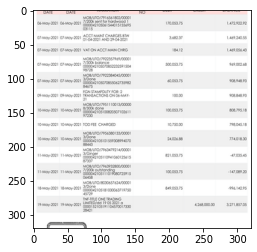


  6%|▋         | 1/16 [00:09<02:20,  9.40s/it]

320 320
320 320


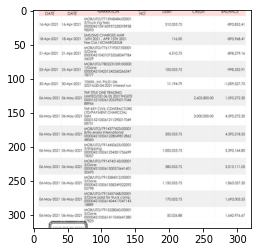


 12%|█▎        | 2/16 [00:19<02:13,  9.55s/it]

320 320
320 320


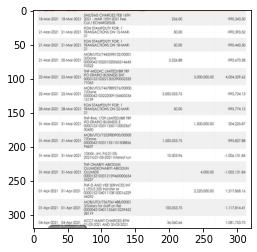


 19%|█▉        | 3/16 [00:29<02:06,  9.71s/it]

320 320
320 320


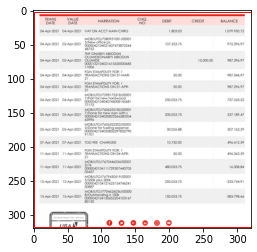


 25%|██▌       | 4/16 [00:39<01:58,  9.86s/it]

320 320
320 320


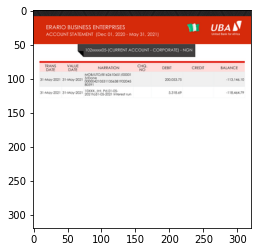


 31%|███▏      | 5/16 [00:49<01:48,  9.84s/it]

320 320
320 320


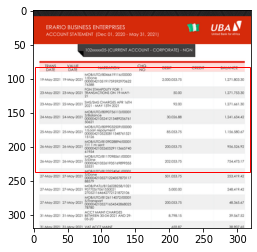


 38%|███▊      | 6/16 [00:58<01:37,  9.75s/it]

320 320
320 320


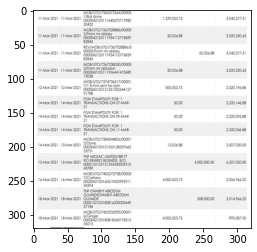


 44%|████▍     | 7/16 [01:08<01:28,  9.78s/it]

320 320
320 320


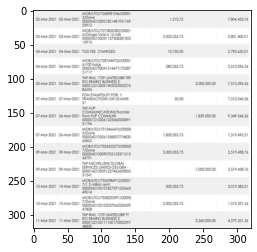


 50%|█████     | 8/16 [01:18<01:18,  9.83s/it]

320 320
320 320


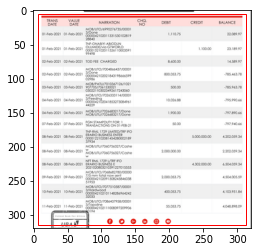


 56%|█████▋    | 9/16 [01:28<01:08,  9.83s/it]

320 320
320 320


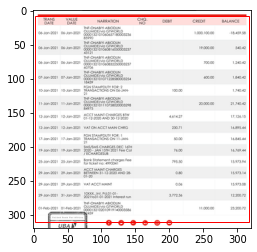


 62%|██████▎   | 10/16 [01:39<01:00, 10.09s/it]

320 320
320 320


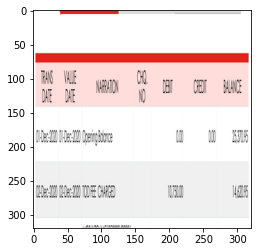


 69%|██████▉   | 11/16 [01:48<00:49,  9.96s/it]

320 320
320 320


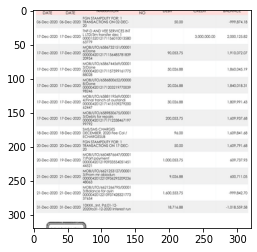


 75%|███████▌  | 12/16 [01:59<00:40, 10.09s/it]

320 320
320 320


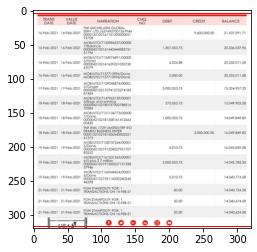


 81%|████████▏ | 13/16 [02:10<00:31, 10.37s/it]

320 320
320 320


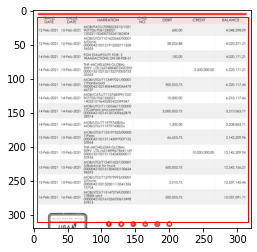


 88%|████████▊ | 14/16 [02:21<00:20, 10.48s/it]

320 320
320 320


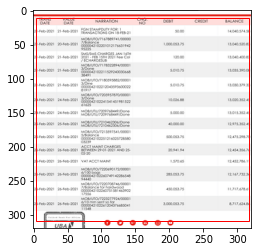


 94%|█████████▍| 15/16 [02:31<00:10, 10.35s/it]

320 320
320 320


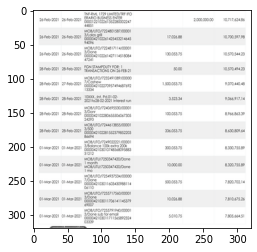


100%|██████████| 16/16 [02:41<00:00, 10.07s/it]


In [12]:
for my_image in tqdm.tqdm(erario):

    detect_LL(my_image)
    try:
        xc, yc, w, h = detect_LL(my_image)[0][2]

        x0 = xc-0.5*w
        y0 = yc-0.5*h
        w0 = w
        h0 = h 
        
        x_corrected = min(160 - 0.5*(x0+w), x0)
        w_corrected = 2*(160 - x_corrected)
        h_corrected = 2*(160 - y0)
        #y_corrected = min(160 - 0.5*(y0+w), x0)
        im_test = original.crop((int(width_original*x_corrected/320), 
                   int(height_original*y0/320), 
                   max(int(width_original*x_corrected/320) + int(width_original*w_corrected/320), width_original), 
                   max(int(height_original*y0/320) + int(height_original*h_corrected/320),height_original)))
        # Create a Rectangle patch
        rect = patches.Rectangle((x_corrected, y0), 
                                 w_corrected, 
                                 h_corrected, 
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')

    except:
        x0 = 0
        y0 = 0
        w0 = 0
        h0 = 0
        im_test = original
        
    im = Image.open(my_image).resize((320,320), Image.ANTIALIAS)
    original = Image.open(my_image)
    width_original, height_original = original.size
    
 
    my_image_extension = my_image.split(".")[-1]
    
    im_test.save(my_image.replace(my_image_extension, f"_cropped.{my_image_extension}"), quality=95)
    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)


    try:
        # Add the patch to the Axes
        ax.add_patch(rect)
    except :
        pass
    plt.show()